# Experiment - Data Preparation Techniques
* StelllarAlgo Data Science
* Ryan Kazmerik, Grant Donst, Peter Morrison
* Dec 02, 2022

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from shared_utilities import helpers
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from pycaret.classification import *

## Let's load in a training dataset from Redshift:

In [2]:
CLUSTER = "prod-app"
DATABASE = "stlrflames"
LKUPCLIENTID = "36"
SCORING_YEAR = 2022
PRODUCT_MAPPING = {'Flex Plan': 0, 'Mini Plan': 1, 'Quarter Season': 2, 'Half Season': 3, 'Full Season': 4}
PRODUCT_CURRENT_MAPPING = {'Individual': 0, 'Group': 1, 'Mini Pack': 2, 'Quarter': 3, 'Half Season': 4, 'Full Season': 5}

In [3]:
dataset = helpers.get_product_propensity_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    scoring_year=SCORING_YEAR,
    type_flag=0
)

dataset.shape

Authorized as AROASQ4JELIXYLYV6P4UV:pmorrison@stellaralgo.com


(670799, 27)

### Let's choose a smaller set of features for this experiment:

In [4]:
features = [
    "atp_last",
    "attended_last",
    "distance",
    "events_last",
    "spend_current",
    "sends",
    "tenure",
    "opens",
    "product",
    "volume_current"
]

In [5]:
df = dataset.copy()

In [6]:
df = df[features]
df.shape

(670799, 10)

### Let's filter our data to product plans only:

In [7]:
product_plans = [
   "Full Season",
   "Half Season",
   "Quarter",
   "Mini Pack"
]

In [8]:
df = df[df["product"].isin(product_plans)].reset_index(drop=True)
df.shape

(26573, 10)

In [9]:
df_before = df

## Let's visualize the dimensionality of our dataset:

In [10]:
df_before["product_encoded"] = df_before["product"].astype("category").cat.codes
df_before = df_before.drop(["product"], axis=1)

In [11]:
df_before = df_before.dropna()

### We can use PCA to represent all of our features in three aggregated features:

In [12]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_before)

df_before['pca-one'] = pca_result[:,0]
df_before['pca-two'] = pca_result[:,1] 
df_before['pca-three'] = pca_result[:,2]

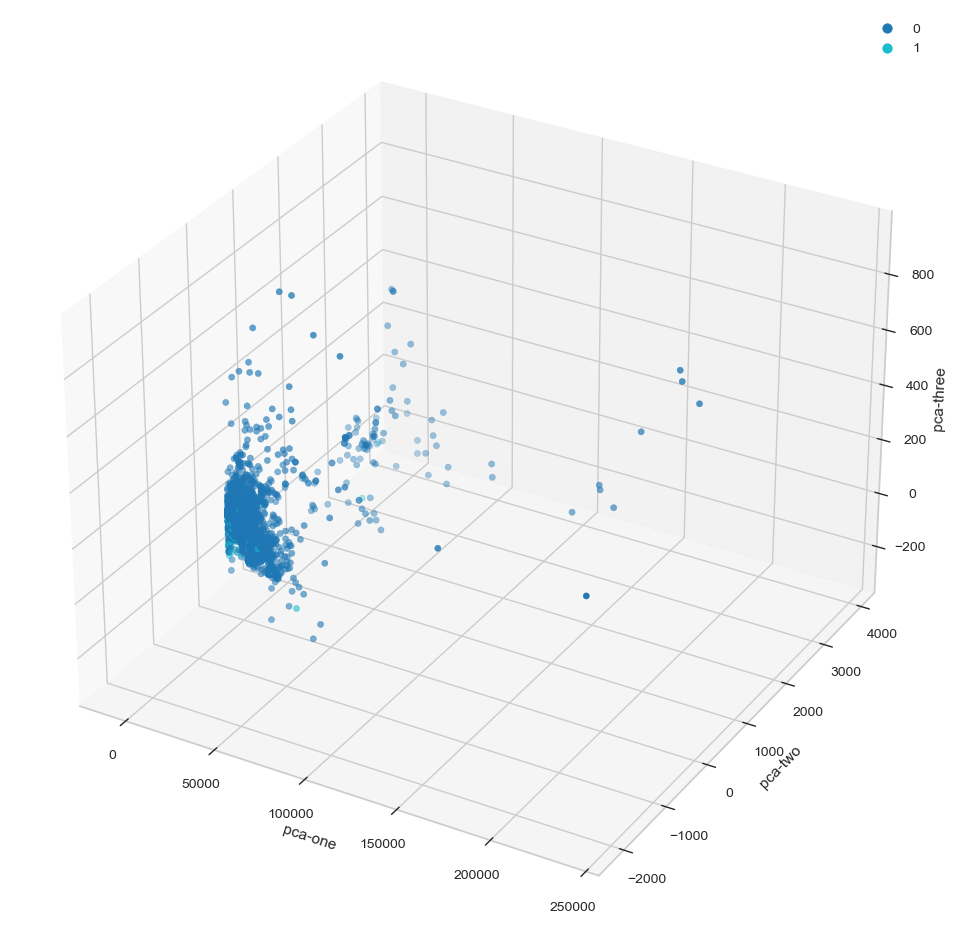

In [13]:
ax = plt.figure(figsize=(12,12)).gca(projection='3d')
chart = ax.scatter(
   xs=df_before["pca-one"], 
   ys=df_before["pca-two"], 
   zs=df_before["pca-three"], 
   c=df_before["product_encoded"], 
   cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

ax.legend(*chart.legend_elements())
plt.show()

## Let's try imputing some missing values:

In [14]:
df["atp_last"] = df["atp_last"].fillna(method="backfill")

In [15]:
df["attended_last"] = df["attended_last"].fillna(method="backfill")
df["events_last"] = df["events_last"].fillna(method="backfill")

In [16]:
df["opens"] = df["opens"].fillna(method="backfill")
df["sends"] = df["sends"].fillna(method="backfill")

## Let's remove some outliers from our data:

In [17]:
def subset_by_iqr(df, column, whisker_bottom=1.5, whisker_top=1.5):
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_bottom*iqr) & (df[column] <= q3 + whisker_top*iqr)
    return df.loc[filter]       

In [18]:
df = subset_by_iqr(df, 'atp_last', 1.0)
df = subset_by_iqr(df, 'spend_current', 1.5, 1.0)
df = subset_by_iqr(df, 'distance', 1.5, 1.5)
df = subset_by_iqr(df, 'opens', 1.5, 1.0)
df = subset_by_iqr(df, 'volume_current', 1.5, 1.0)
df.shape

(10910, 11)

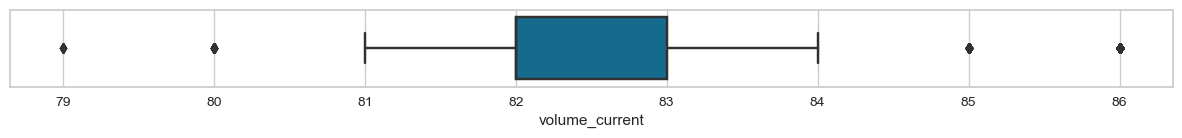

In [19]:
plt.figure(figsize=(15,1))
sns.boxplot(x=df["volume_current"])
plt.show()

## Let's resample our data using SMOTE to fix class imbalance on our target variable:

In [20]:
df = df.dropna()

In [21]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df.drop(["product"], axis=1), df["product"])

In [22]:
df = X_res
df["product"] = y_res

In [23]:
df.head()

,atp_last,attended_last,distance,events_last,spend_current,sends,tenure,opens,volume_current,product_encoded,product
0,200.38,41.0,23.41,41.0,16430.78,63.0,1,5.0,82,0,Full Season
1,200.38,41.0,23.41,41.0,16430.78,63.0,2,5.0,82,1,Half Season
2,37.63,7.0,9.09,41.0,3236.32,22.0,1,11.0,86,0,Full Season
3,37.63,7.0,9.09,41.0,3786.02,22.0,2,11.0,86,0,Full Season
4,200.38,12.0,7.05,41.0,16430.78,5.0,1,1.0,82,0,Full Season


In [24]:
df.shape

(21632, 11)

## Let's check the datatypes infered by Pandas to see if they are correct:

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21632 entries, 0 to 21631
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   atp_last         21632 non-null  float64
 1   attended_last    21632 non-null  float64
 2   distance         21632 non-null  float64
 3   events_last      21632 non-null  float64
 4   spend_current    21632 non-null  float64
 5   sends            21632 non-null  float64
 6   tenure           21632 non-null  int64  
 7   opens            21632 non-null  float64
 8   volume_current   21632 non-null  int64  
 9   product_encoded  21632 non-null  int8   
 10  product          21632 non-null  object 
dtypes: float64(7), int64(2), int8(1), object(1)
memory usage: 1.7+ MB


## Let's visualize the dimensionality of our dataset:

In [26]:
df["product_encoded"] = df["product"].astype("category").cat.codes
df = df.drop(["product"], axis=1)

In [27]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

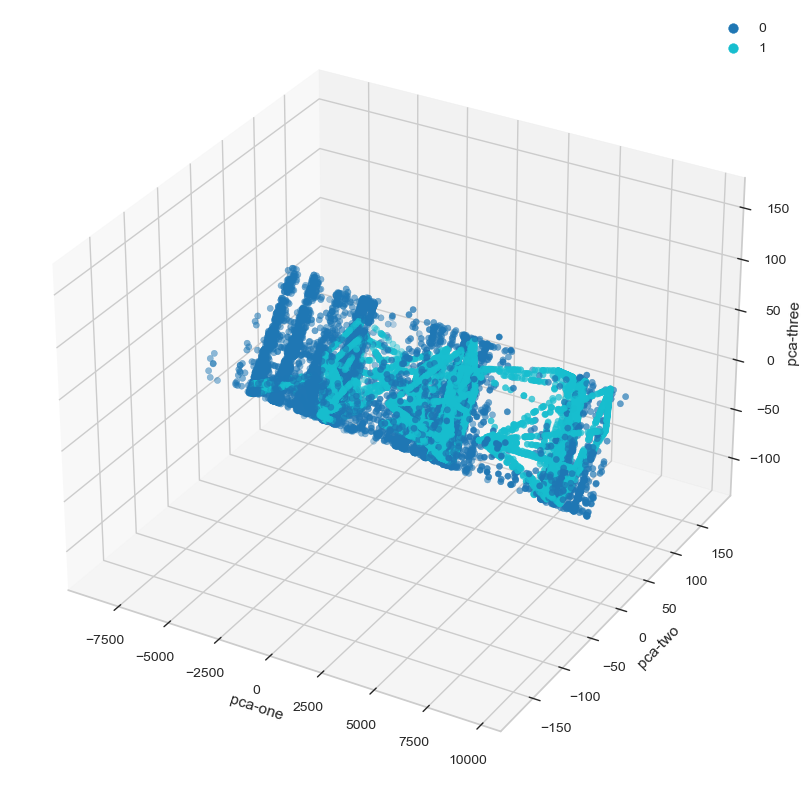

In [28]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
chart = ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["product_encoded"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

ax.legend(*chart.legend_elements())
plt.show()

### We have reduced the dimensionality of our dataset quite a bit and the vector space required to capture each data point is much smaller.

# Done